In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn.preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import datetime

In [2]:
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import keras.optimizers as optimizer

Using TensorFlow backend.
/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

## Read-in data and Clean
In this section:
* **Load csv file** - Use Pandas to create a Dataframe  object.
* **Remove duplicates** - prevent having duplicate dates.
* **Check for null values** - do not impute mean before train-test split to avoid data leaking.
* **Visualize data** - See the energy consumption as a function of time.

### East Region
Read in the data for the Eastern region setting the index as datetime. Parsing the dates allows pandas to recognize it as a datetime object. Sort the index to appear in the correct order inn the dataframe.

In [3]:
df = pd.read_csv('data/PJME_hourly.csv', parse_dates=['Datetime'])
df = df.drop_duplicates(subset='Datetime').set_index('Datetime').sort_index()
df.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


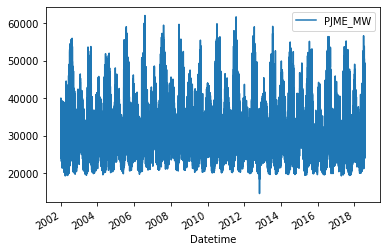

In [4]:
# Check for parsing as won't plot if False

df.plot()

## Prepare for Modeling
In this section:
* **Scale the data** - Normalize values between 0 and 1, saving time on training.
* **Perform train-test split** -  Want to predict final year so make this the test set.


### Scale

In [5]:
scale = sklearn.preprocessing.MinMaxScaler()
df['PJME_MW'] = scale.fit_transform(df['PJME_MW'].values.reshape(-1,1))


### Train-Test Split

In [6]:
def prepare_data(data, sequence):
    X = []
    y = []
    for i in range(sequence, len(data)):
        X.append(data.iloc[i-sequence : i, 0])
        y.append(data.iloc[i, 0])
    
    
    # Train-test split
    train = int(data.shape[0] * 0.8) # 80%
    
    X_train = np.array(X[:train])       
    y_train = np.array(y[:train])
    X_test = np.array(X[train:])             
    y_test = np.array(y[train:])
    
    
    # Reshape data for RNN
    X_train = np.reshape(X_train, (train, sequence, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], sequence, 1))
    
    return X_train, y_train, X_test, y_test

In [7]:
# Sequence length for testing
sequence = 40
X_train, y_train, X_test, y_test = prepare_data(df, sequence)

# Create validation from test
val = int(X_train.shape[0] * 0.05)
X_train, y_train, X_val, y_val = X_train[val:], y_train[val:], X_train[:val], y_train[:val]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(110475, 40, 1) (110475,) (29033, 40, 1) (29033,) (5814, 40, 1) (5814,)


## RNN

In [8]:
rnn = Sequential()

rnn.add(SimpleRNN(units=50, input_shape=(X_train.shape[1],1), return_sequences=True))

rnn.add(SimpleRNN(units=50, return_sequences=True))
rnn.add(Dropout(0.1))

rnn.add(SimpleRNN(units=50, return_sequences=False))
rnn.add(Dropout(0.2))

rnn.add(Dense(1))

rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 40, 50)            2600      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 40, 50)            5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 50)            0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 12,751
Trainable params: 12,751
Non-trainable params: 0
_________________________________________________________________


In [14]:
rnn.compile(optimizer="adam",loss="MSE")
rnn.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=10, batch_size=5000)

Train on 110475 samples, validate on 5814 samples
Epoch 1/10
110475/110475 [==============================] - 35s 313us/step - loss: 3.0479e-04 - val_loss: 1.1369e-04
Epoch 2/10
110475/110475 [==============================] - 30s 272us/step - loss: 1.9487e-04 - val_loss: 8.4087e-05
Epoch 3/10
110475/110475 [==============================] - 29s 266us/step - loss: 1.7958e-04 - val_loss: 9.1828e-05
Epoch 4/10
110475/110475 [==============================] - 29s 265us/step - loss: 1.7850e-04 - val_loss: 8.2348e-05
Epoch 5/10
110475/110475 [==============================] - 31s 279us/step - loss: 1.7449e-04 - val_loss: 8.7739e-05
Epoch 6/10
110475/110475 [==============================] - 29s 264us/step - loss: 1.7495e-04 - val_loss: 9.7667e-05
Epoch 7/10
110475/110475 [==============================] - 30s 267us/step - loss: 1.7619e-04 - val_loss: 8.2206e-05
Epoch 8/10
110475/110475 [==============================] - 29s 262us/step - loss: 1.7296e-04 - val_loss: 8.4916e-05
Epoch 9/10
110

In [15]:
predict = rnn.predict(X_test)

In [16]:
x = scale.data_max_
mean_absolute_error(predict*x, y_test*x), mean_squared_error(predict*x, y_test*x)

(338.9552558971114, 195501.5387531654)

In [17]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual')
    plt.plot(predicted, alpha=0.7, color='red',label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized MW')
    plt.legend()
    plt.show()


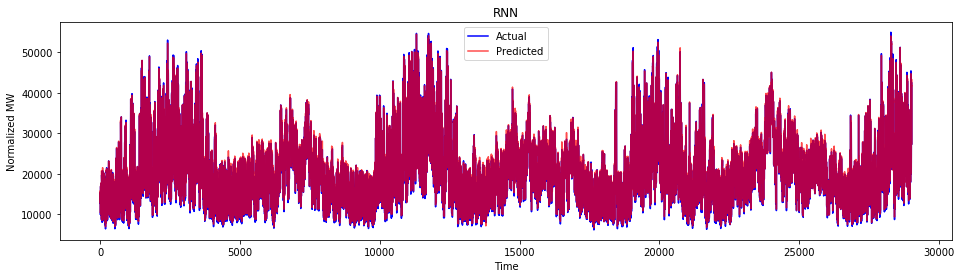

In [19]:
# Full dataset
plot_predictions(y_test*x, predict*x, 'RNN')

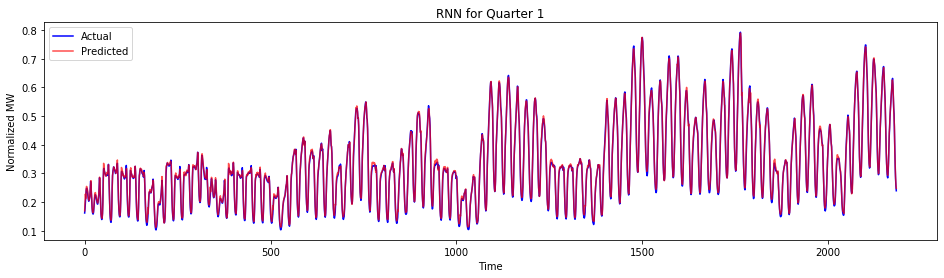

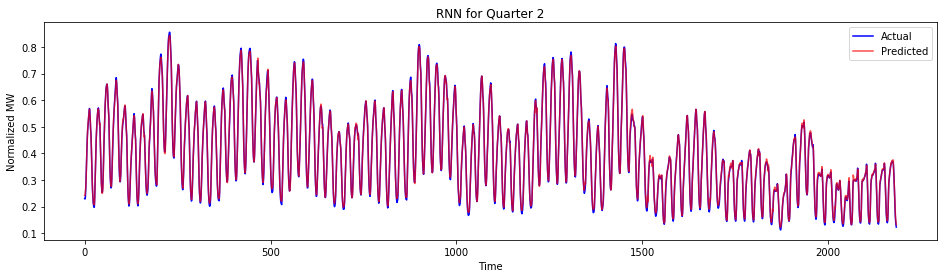

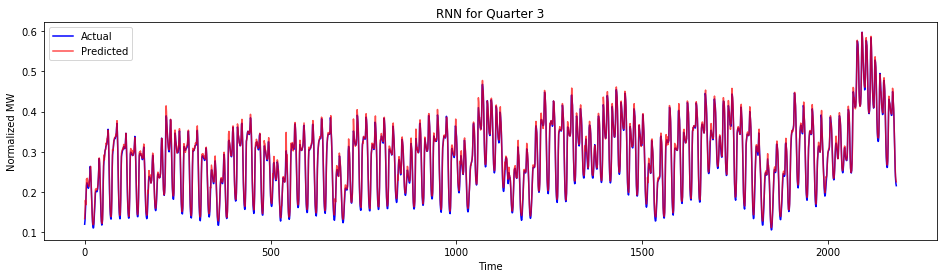

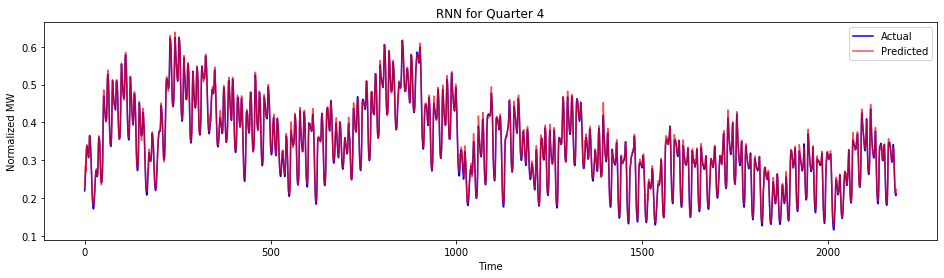

In [20]:
# Per Quarter
quarter = (24*7*13)
for i in range(0,4):
    plot_predictions(y_test[quarter*i:quarter*(i+1)], predict[quarter*i:quarter*(i+1)], f'RNN for Quarter {i+1}')

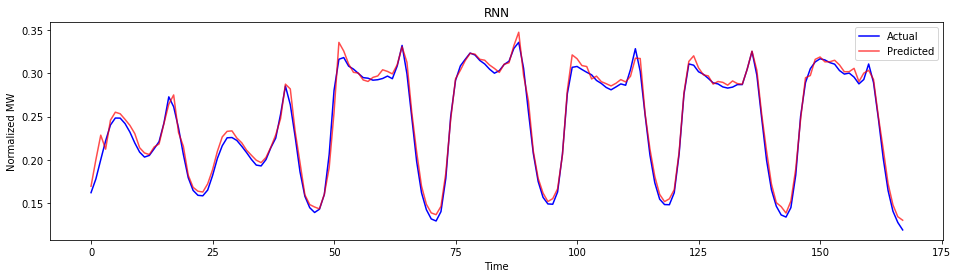

In [21]:
# Average week
plot_predictions(y_test[0:(24*7)], predict[0:(24*7)], 'RNN')

## LSTM

In [162]:
# Sequence length for testing
sequence = 10
X_train, y_train, X_test, y_test = prepare_data(df, sequence)

# Create validation from test
#val = int(X_train.shape[0] * 0.05)
#X_train, y_train, X_val, y_val = X_train[val:], y_train[val:], X_train[:val], y_train[:val]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)#, print(X_val.shape, y_val.shape)

(116289, 20, 1) (116289,) (29053, 20, 1) (29053,)


In [170]:
lstm = Sequential()

lstm.add(LSTM(units=40, input_shape=(X_train.shape[1],1), return_sequences=True, activation='tanh'))

lstm.add(LSTM(units=40, return_sequences=True, activation='tanh'))
lstm.add(Dropout(0.1))

lstm.add(LSTM(units=40, return_sequences=True, activation='tanh'))
lstm.add(Dropout(0.1))

lstm.add(LSTM(units=40, return_sequences=False, activation='tanh'))
lstm.add(Dropout(0.15))

lstm.add(Dense(1))

lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_95 (LSTM)               (None, 20, 40)            6720      
_________________________________________________________________
lstm_96 (LSTM)               (None, 20, 40)            12960     
_________________________________________________________________
dropout_67 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
lstm_97 (LSTM)               (None, 20, 40)            12960     
_________________________________________________________________
dropout_68 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
lstm_98 (LSTM)               (None, 40)                12960     
_________________________________________________________________
dropout_69 (Dropout)         (None, 40)                0         
__________

In [171]:
es = EarlyStopping(monitor='loss', min_delta=0, patience=5, verbose=True)
opt = optimizer.Adam(lr=0.01)
lstm.compile(opt, loss='MSE')
lstm.fit(X_train, y_train, epochs=20, batch_size=2000, callbacks=[es]) #validation_data=(X_val,y_val)


Epoch 1/20
116289/116289 [==============================] - 62s 529us/step - loss: 0.0357
Epoch 2/20
116289/116289 [==============================] - 50s 432us/step - loss: 0.0103
Epoch 3/20
116289/116289 [==============================] - 57s 488us/step - loss: 0.0024
Epoch 4/20
116289/116289 [==============================] - 56s 484us/step - loss: 0.0019
Epoch 5/20
116289/116289 [==============================] - 59s 506us/step - loss: 0.0012
Epoch 6/20
116289/116289 [==============================] - 51s 438us/step - loss: 8.9100e-04
Epoch 7/20
116289/116289 [==============================] - 49s 425us/step - loss: 8.0700e-04
Epoch 8/20
116289/116289 [==============================] - 63s 538us/step - loss: 7.0718e-04
Epoch 9/20
116289/116289 [==============================] - 63s 545us/step - loss: 6.7728e-04
Epoch 10/20
116289/116289 [==============================] - 64s 548us/step - loss: 6.0527e-04
Epoch 11/20
116289/116289 [==============================] - 64s 553us/step - l

In [172]:
predict_lstm = lstm.predict(X_test)

In [173]:
x = scale.data_max_
mean_absolute_error(predict_lstm*x, y_test*x), mean_squared_error(predict_lstm*x, y_test*x)

(510.4221826310293, 428104.7577293443)

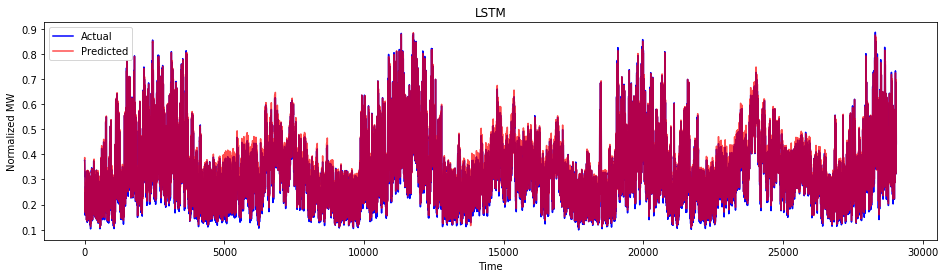

In [174]:
# Full dataset
plot_predictions(y_test, predict_lstm, 'LSTM')

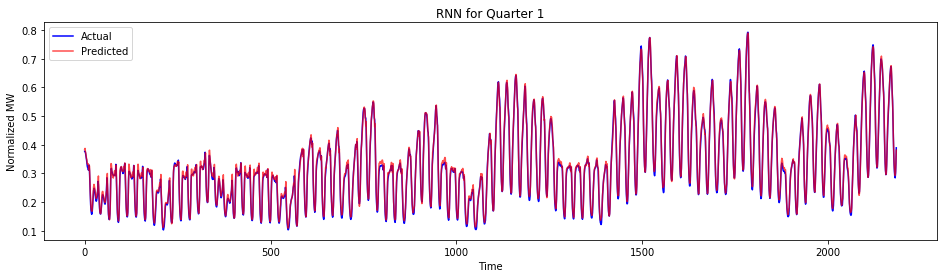

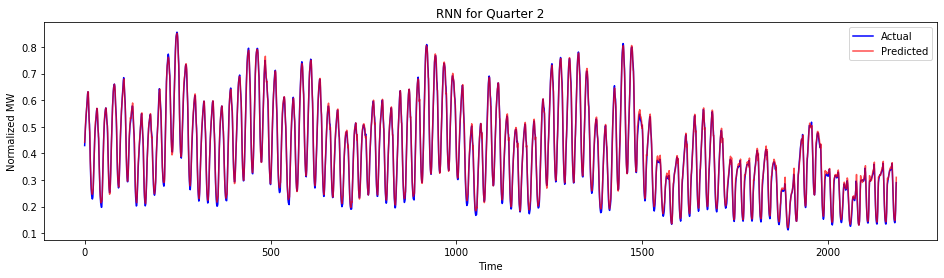

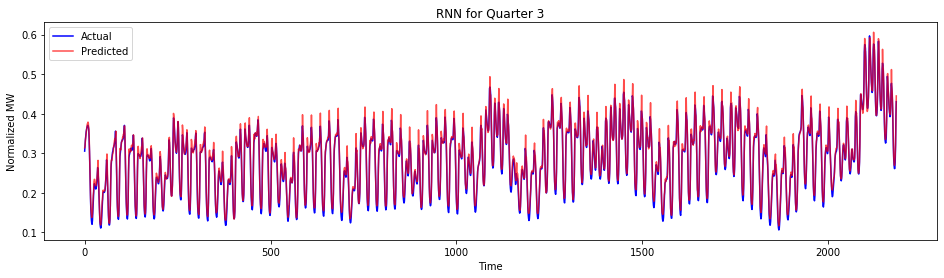

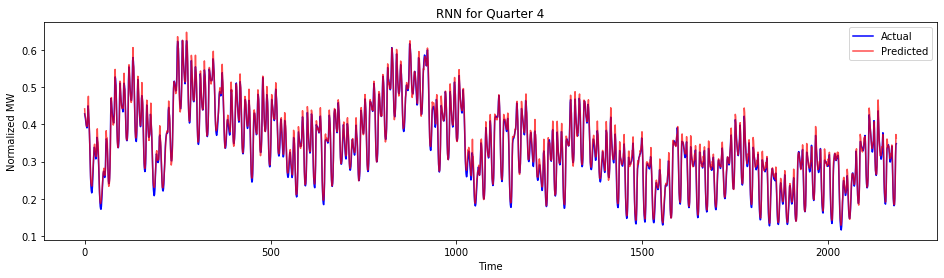

In [175]:
# Per Quarter
quarter = (24*7*13)
for i in range(0,4):
    plot_predictions(y_test[quarter*i:quarter*(i+1)], predict_lstm[quarter*i:quarter*(i+1)], f'RNN for Quarter {i+1}')

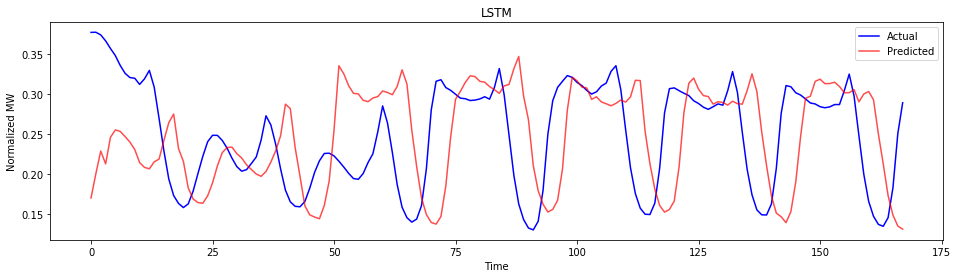

In [176]:
# Average week
plot_predictions(y_test[0:(24*7)], predict[0:(24*7)], 'LSTM')

There seems to be some lag here and the overall error for this model is larger than the RNN. RNNs also run much faster and minimised the loss quicker therefore are a more suitable choice in this case.